### outline

#### parte 1
. importar dados observados (BNDO)

. tratar os dados e deixar preparado para plotagem

#### parte 2
. importar dados modelados (sECOM)

. tratar e configurar para o mesmo período dos dados observados

. plotar cada série de forma separada

#### parte 3
. plotar as duas séries juntas

. comparar os dados

In [2]:
# importar funções
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import cKDTree
import glob
import xray as xr

import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
# diretorio base
BASE_DIR = '/home/tparente/danilo/mestrado/artigo_tg/'
DATA_DIR = BASE_DIR + 'dados_bndo/'
SIMS_DIR = BASE_DIR + 'simulacoes/val3/'

# Parte 1

In [4]:

lfiles = glob.glob(DATA_DIR+'1997/*')
lfiles.sort()

# ler, inicialmente, os dois primeiros arquivos para ampliar uma série
files = lfiles[:1]
files

['/home/tparente/danilo/mestrado/artigo_tg/dados_bndo/1997/0_50165002731812199631011997ALT.txt']

In [5]:
file1 = pd.read_csv(files[0], skiprows=11, delimiter=';', names=['nivel', 'x'])
file1.drop(file1.columns[len(file1.columns)-1], axis=1, inplace=True)
# criar um daterange novo, pra poder utilizar os index legal
dtRange = pd.date_range(start=file1.index[0], end=file1.index[-1], freq='H')

observ = pd.DataFrame({'nivel': file1['nivel'].values/100.}, index=dtRange)

# controle de qualidade
cond = observ['nivel'] > 4.
observ[cond] = np.nan

# removendo a média da série temporal
observ['nivel'] = observ['nivel'] - observ['nivel'].mean()


In [6]:
# checar os extremos da série para verificar: data e valor
print('Primeiro registro: ')
print(observ.head())
print('-------------------')
print('Último registro: ')
print(observ.tail())

Primeiro registro: 
                        nivel
1996-12-18 00:00:00 -0.049018
1996-12-18 01:00:00  0.050982
1996-12-18 02:00:00  0.040982
1996-12-18 03:00:00 -0.149018
1996-12-18 04:00:00 -0.349018
-------------------
Último registro: 
                        nivel
1997-01-31 19:00:00  0.110982
1997-01-31 20:00:00  0.110982
1997-01-31 21:00:00  0.110982
1997-01-31 22:00:00  0.010982
1997-01-31 23:00:00 -0.019018


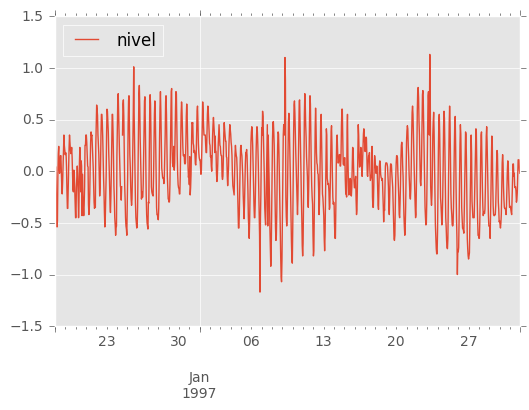

In [7]:
# visualizacao da série original com frequência horária
observ.plot()

In [8]:
# resample para alterar frequência para 6 em 6 horas
obs = observ.resample('3H').mean()
obs.head()

# importante: irei tomar os dados de 6 em 6 horas, mas a partir das 3:00

,nivel
1996-12-18 00:00:00,0.014316
1996-12-18 03:00:00,-0.345684
1996-12-18 06:00:00,-0.119018
1996-12-18 09:00:00,0.087649
1996-12-18 12:00:00,0.117649


In [9]:
obs.index[0]

Timestamp('1996-12-18 00:00:00', offset='3H')

In [10]:
# loop para remover os valores em horários que não desejo
hours = [3, 9, 15, 21]

dado = []
time = []
for i in np.arange(len(obs)):
    if obs.index.hour[i] in hours:
        dado.append(obs.nivel[i])
        time.append(obs.index[i])

# converter para dataframe
observ = pd.DataFrame({'nivel':dado},index=time)
observ.tail()

,nivel
1997-01-30 21:00:00,-0.232351
1997-01-31 03:00:00,-0.355684
1997-01-31 09:00:00,-0.072351
1997-01-31 15:00:00,-0.262351
1997-01-31 21:00:00,0.034316


In [11]:
observ.shape

(180, 1)

# Parte 2

In [12]:
# importar grade do modelo
ncfile = xr.open_dataset(SIMS_DIR+'gcmplt.cdf')

lon = ncfile['lon'].data
lat = ncfile['lat'].data

lon[lon == 0.0] = np.nan
lat[lon == 0.0] = np.nan

In [13]:
# localizacao do terminal da ilha guaiba

ilat = -23.00000000
ilon = -44.01916667

lo = lon.ravel()
la = lat.ravel()

coords = []

for i,j in zip(la,lo):
    coords.append([i,j])

coords = np.array(coords)

locations_name = ['Terminal Ilha Guaiba']
locations_posi = [[ilat,ilon]]

locs = np.asarray(locations_posi)

tree = cKDTree(coords)
# procura em tree os pontos mais próximos dos pontos definidos acima
dists,indexes = tree.query(locs,k=1)

pontos = []

for index in indexes:
    pontos.append(coords[index])

# converter de lista para array
pontos = np.asarray(pontos)

# findind indexes from lat and lon
ind = []

for p in pontos:
    ind.append(np.where(lon == p[1]))

ind = np.asarray(ind)

# vetores para separar i e j para facilitar resgatar os dados de concentração
iss=[]
jss=[]

for i,j in ind:
    iss.append(int(i))
    jss.append(int(j))
    
iss,jss

([193], [26])

In [14]:
# importar dados do modelo
elev = ncfile['elev'].data[68:247,iss,jss]
elev = np.squeeze(elev)

elev.shape

(118,)

In [15]:
# time = ncfile['time'][68:247] # 1997-01-31 23:00:00
time = ncfile['time'][68:]
time[-1].values

numpy.datetime64('1997-01-16T09:00:00.000000000')

In [16]:
model = pd.DataFrame({'modeled':elev}, index=time)

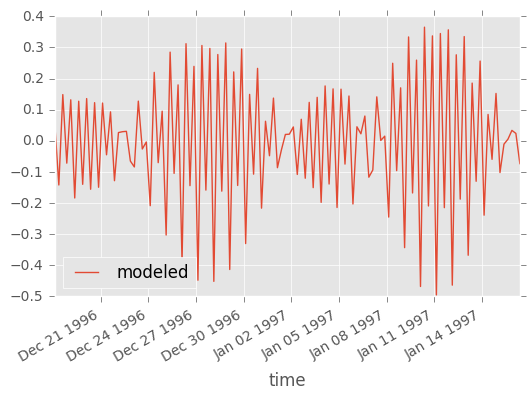

In [17]:
model['1996-12-18 03:00':'1997-01-16 09:00'].plot()

# Parte 3 - Juntando tudo

In [74]:
observ[:len(observ)-1].shape

(179, 1)

In [75]:
model.index

DatetimeIndex(['1996-12-18 03:00:00', '1996-12-18 09:00:00',
               '1996-12-18 15:00:00', '1996-12-18 21:00:00',
               '1996-12-19 03:00:00', '1996-12-19 09:00:00',
               '1996-12-19 15:00:00', '1996-12-19 21:00:00',
               '1996-12-20 03:00:00', '1996-12-20 09:00:00',
               ...
               '1997-01-14 03:00:00', '1997-01-14 09:00:00',
               '1997-01-14 15:00:00', '1997-01-14 21:00:00',
               '1997-01-15 03:00:00', '1997-01-15 09:00:00',
               '1997-01-15 15:00:00', '1997-01-15 21:00:00',
               '1997-01-16 03:00:00', '1997-01-16 09:00:00'],
              dtype='datetime64[ns]', name=u'time', length=118, freq=None)

In [19]:
df = pd.DataFrame({'sECOM': model['modeled'].values[:],
                   'BNDO': observ['1996-12-18 03:00':time[-1].values].nivel.values },
                   index=model.index)

In [20]:
# df = pd.DataFrame({'sECOM': model['modeled'].values[:], 
#                    'BNDO': observ.nivel[:len(observ)-1].values}, 
#                    index=model.index)

In [27]:
c=df.corr()

correlation = c['sECOM'][0]

c

,BNDO,sECOM
BNDO,1.000000,-0.655862
sECOM,-0.655862,1.000000


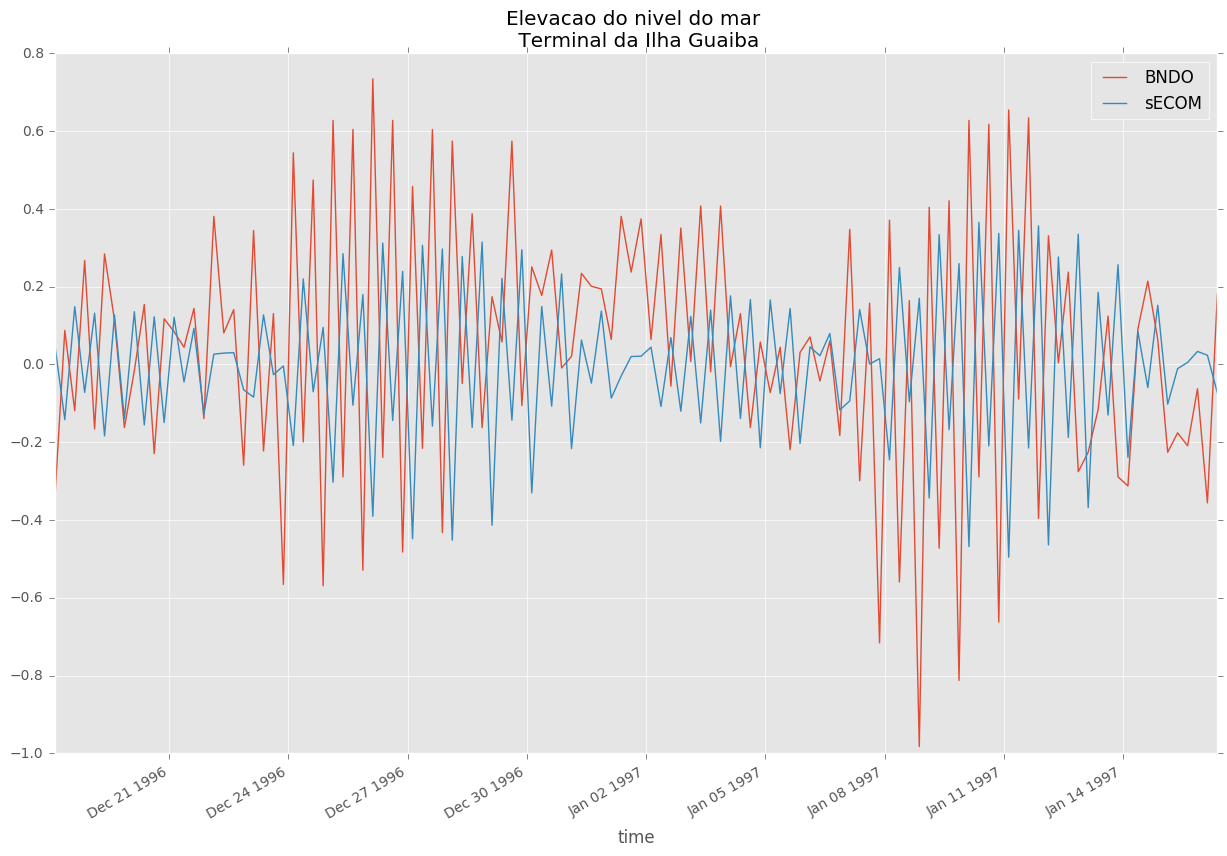

In [28]:
ax = df.plot(title='Elevacao do nivel do mar \n Terminal da Ilha Guaiba',figsize=(15,10))
# ax.text(0.5,0.5,correlation)

### Validando com skill

In [29]:
def skill_willmott(re,m):
    """
    Analise de Skill (Willmott, 1981) em Python
    Esta funcao esta definida como no trabalho de Miranda et al 2012 (BRAZILIAN JOURNAL OF OCEANOGRAPHY, 60(1):11-23, 201)
    CIRCULATION AND SALT INTRUSION IN THE PIACAGUERA CHANNEL, SANTOS (SP)
    Based on the MSE , a quantitative model skill was presented by Willmott (1981)
    The highest value, WS = 1, means perfect agreement between model and observation, while the lowest value,  WS = 0,
    indicates   complete     disagreement. Recently, this was used to evaluate ROMS in the simulation of multiple parameters in the
    Hudson River estuary [ Warner et al., 2005b] and on the southeast New England Shelf [Wilkin ,2006].
    The Willmott skill will be used to  quantify model performance in simulating different parameters from the best model run
    skill parameter (WILLMOTT, 1981)
    Parameters: 
    re - real data
    m - model data
    skill - Skill parameter
    funcao traduzida por: Paula Birocchi
    """
    dif   = re - m 
    soma  = np.nansum(abs(dif)**2) 
    somam = m - np.nanmean(re)  
    c     = re - np.nanmean(re)
    d     = np.nansum((abs(somam) + abs(c))**2)
    skill = 1 - (soma/d)
    return skill

In [31]:
skill = skill_willmott(df['BNDO'].values, df['sECOM'].values)

skill

0.065644771378934208

## Alterando (atrasando/adiantando) a maré do modelo para melhorar skill

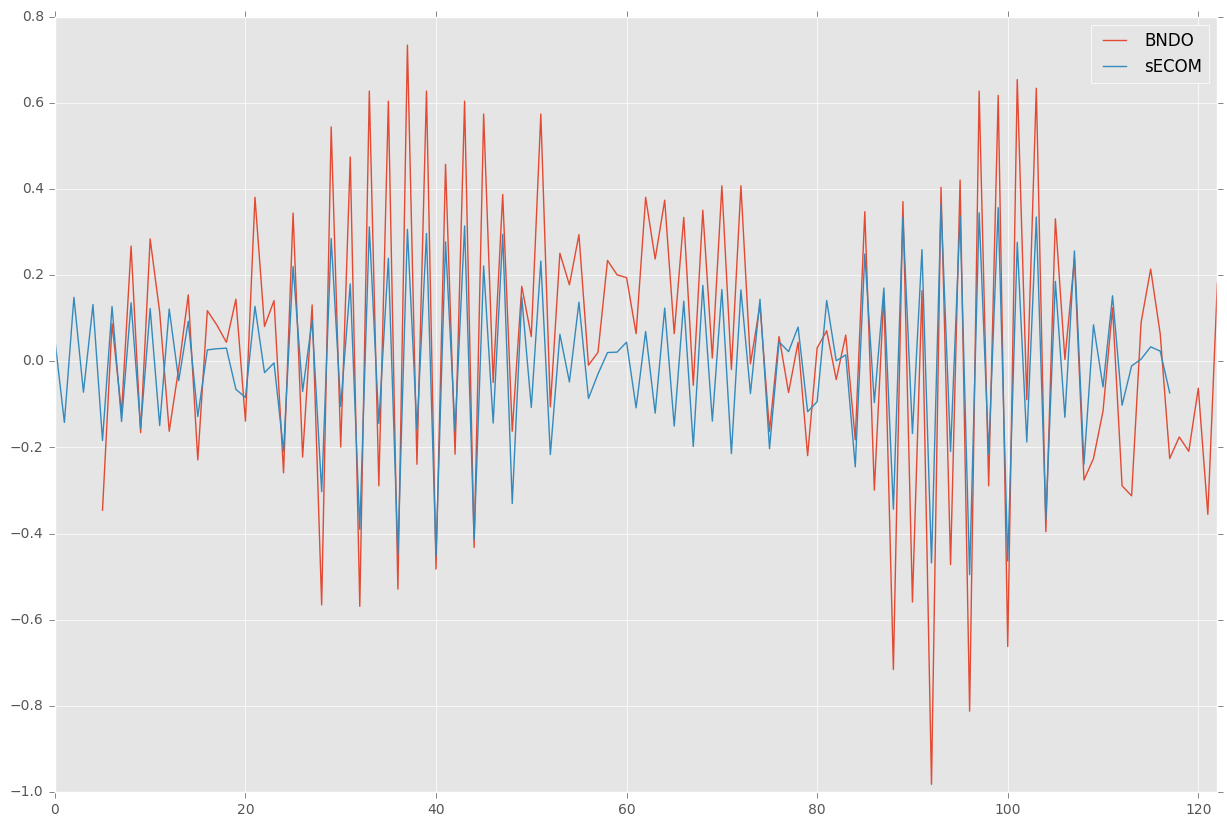

In [84]:
secom = df['sECOM'].values
bndo  = df['BNDO'].values

secom = np.asarray([
        0.05066382, -0.14191973,  0.14863421, -0.07172287,  0.13184801,
       -0.18373264,  0.12726995, -0.1397833 ,  0.13581566, -0.1556539 ,
        0.1226919 , -0.14924462,  0.12147108, -0.04486495,  0.09308713,
       -0.12818556,  0.02655272,  0.02929956,  0.03052037, -0.06500839,
       -0.08393102,  0.12757516, -0.02624752, -0.00366244, -0.20845414,
        0.22005188, -0.07019686,  0.09522356, -0.30276209,  0.28506028,
       -0.10468488,  0.17976499, -0.39035556,  0.31222341, -0.14405616,
        0.23927972, -0.44803906,  0.30642454, -0.15840073,  0.29696322,
       -0.45170151,  0.27743018, -0.16175797,  0.31466504, -0.41355104,
        0.2215779 , -0.14344575,  0.295132  , -0.33023043,  0.14924462,
       -0.10712651,  0.23287044, -0.21638944,  0.06287197, -0.04791698,
        0.13734167, -0.08637265, -0.02929956,  0.02044865,  0.02136426,
        0.04455974, -0.10804212,  0.06928124, -0.12025027,  0.12360751,
       -0.15046543,  0.1397833 , -0.19777201,  0.17640775, -0.13886769,
        0.16694644, -0.21425301,  0.16603082, -0.07477491,  0.14405616,
       -0.20296047,  0.04517015,  0.02258508,  0.07965817, -0.11689303,
       -0.09369754,  0.14130932,  0.00122081,  0.01495498, -0.24507859,
        0.24935144, -0.09583397,  0.17030368, -0.34335419,  0.33389287,
       -0.16755684,  0.25942316, -0.46818251,  0.36532885, -0.20936975,
        0.33725011, -0.49565084,  0.3448802 , -0.21486342,  0.35678315,
       -0.46390966,  0.27651457, -0.18739508,  0.33511369, -0.36777048,
        0.18556386, -0.13001679,  0.25637113, -0.23897451,  0.08484663,
       -0.05951473,  0.15229666, -0.10193804, -0.01068213,  0.00518846,
        0.03357241,  0.02380589, -0.07324889,
        np.nan, np.nan, np.nan, np.nan, np.nan])

bndo = np.asarray([
        np.nan, np.nan, np.nan, np.nan, np.nan,
        -0.34568428,  0.08764906, -0.11901761,  0.26764906, -0.16568428,
        0.28431572,  0.11431572, -0.16235094, -0.01568428,  0.15431572,
       -0.22901761,  0.11764906,  0.08431572,  0.04431572,  0.14431572,
       -0.13901761,  0.38098239,  0.08098239,  0.14098239, -0.25901761,
        0.34431572, -0.22235094,  0.13098239, -0.56568428,  0.54431572,
       -0.19901761,  0.47431572, -0.56901761,  0.62764906, -0.28901761,
        0.60431572, -0.52901761,  0.73431572, -0.23901761,  0.62764906,
       -0.48235094,  0.45764906, -0.21568428,  0.60431572, -0.43235094,
        0.57431572, -0.04901761,  0.38764906, -0.16235094,  0.17431572,
        0.05764906,  0.57431572, -0.10568428,  0.25098239,  0.17764906,
        0.29431572, -0.00901761,  0.02098239,  0.23431572,  0.20098239,
        0.19431572,  0.06431572,  0.38098239,  0.23764906,  0.37431572,
        0.06431572,  0.33431572, -0.05568428,  0.35098239,  0.00764906,
        0.40764906, -0.01901761,  0.40764906, -0.00568428,  0.13098239,
       -0.16235094,  0.05764906, -0.07235094,  0.04431572, -0.21901761,
        0.03098239,  0.07098239, -0.04235094,  0.06098239, -0.18235094,
        0.34764906, -0.29901761,  0.15764906, -0.71568428,  0.37098239,
       -0.55901761,  0.16431572, -0.98235094,  0.40431572, -0.47235094,
        0.42098239, -0.81235094,  0.62764906, -0.28901761,  0.61764906,
       -0.66235094,  0.65431572, -0.08901761,  0.63431572, -0.39568428,
        0.33098239,  0.00431572,  0.23764906, -0.27568428, -0.22568428,
       -0.11568428,  0.12431572, -0.28901761, -0.31235094,  0.09098239,
        0.21431572,  0.06431572, -0.22568428, -0.17568428, -0.20901761,
       -0.06235094, -0.35568428,  0.18098239])

index = np.arange(len(bndo))

new_df = pd.DataFrame({'sECOM': secom, 'BNDO': bndo}, index=index)

new_df.plot(figsize=(15,10))

new_df.corr()

In [85]:
skill = skill_willmott(new_df['BNDO'].values, new_df['sECOM'].values)

skill

# se multiplicar os valores do modelo por 2, o skil sobe para 0.93

0.87750922880617388

# TESTES de Análise Harmônica

In [23]:
from pytides.tide import Tide

In [24]:
tide = Tide.decompose(observ['nivel'].values, observ.index.to_datetime())

In [25]:
observ.head()

,nivel
1996-12-18 03:00:00,-0.345684
1996-12-18 09:00:00,0.087649
1996-12-18 15:00:00,-0.119018
1996-12-18 21:00:00,0.267649
1996-12-19 03:00:00,-0.165684


In [26]:
constituent = [c.name for c in tide.model['constituent']]

d = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)

d.sort_values(by='amplitude', ascending=False).head(25)

,amplitude,phase
K2,31.115243,213.749179
R2,27.313884,354.749501
T2,17.193946,6.570344
S6,3.477248,90.000000
S2,3.426104,270.046877
L2,0.675454,142.377260
S1,0.525275,324.324493
lambda2,0.387978,21.610184
Mf,0.319255,257.130263
M2,0.318405,64.304039
